In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

### funcs

In [3]:
def Cells_from_alms_fit(datamap, Cinv, max_ell, idx_to_fit=None, return_alms=False):
    """
    Performs a linear least-squares fit to a healpix density map to get best-fit spherical harmonic amplitudes alm.
    Regularize by setting masked pixels (NaN or hp.UNSEEN) to zero counts and assuming `Cinv=1`.
    Returns the Cells as computed from the alms (sum of |alms|^2).
    
    """
    assert datamap.shape == Cinv.shape
    assert datamap.ndim == Cinv.ndim == 1
    
    # get number of pixels from input data map
    NPIX = len(datamap)
    
    # construct Ylm templates -> design matrix
    ells = np.arange(0, max_ell+1)
    templates = construct_templates(ells, hp.npix2nside(NPIX))
    A = templates.T
    
    # indices to fit: non-NaN, non-hp.UNSEEN, non-zero
    if idx_to_fit is None:
        idx_to_fit = np.full(NPIX, True).astype(bool)
    else:
        idx_to_fit = idx_to_fit
    idx_to_fit = idx_to_fit & (datamap != 0) & (~np.isnan(datamap)) & (datamap != hp.UNSEEN)
    map_to_fit, A_fit, Cinv_fit = datamap.copy(), A.copy(), Cinv.copy()
    
    # perform the regression: bestfit_pars are the alms
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
    Cells = compute_Cells(bestfit_pars)
    
    if return_alms == True:
        return ells, Cells, bestfit_pars
    else:
        return ells, Cells

### expected dipole

In [5]:
catwise_dipamp_exp = 0.007
quaia_dipamp_exp = 0.005
cmb_dipdir = dipole.cmb_dipole()[1]

### load samples

In [6]:
# healpix resolution
NSIDE = 64

#### for sky plot: blim = 15deg

In [15]:
# CatWISE overdensity map

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=15, maglim=16.4, load_init=True)
d = SecrestDipole(**catwise_kwargs)
d.cut_mag()
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# fit dipole (and other multipoles) from blim=30 map
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= 30] = 1
mask_blim30 = gal_plane_mask.astype(bool) & small_masks.astype(bool)
masked_datamap_blim30 = np.multiply(datamap, mask_blim30, where=(mask_blim30!=0), out=np.full_like(datamap, np.nan))

# OVERDENSITIES
overdensity_map_catwise = masked_datamap_blim30 / np.nanmean(masked_datamap_blim30) - 1

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.


In [8]:
# smooth map (steradian scale)
smoothed_map = tools.smooth_map(masked_datamap)

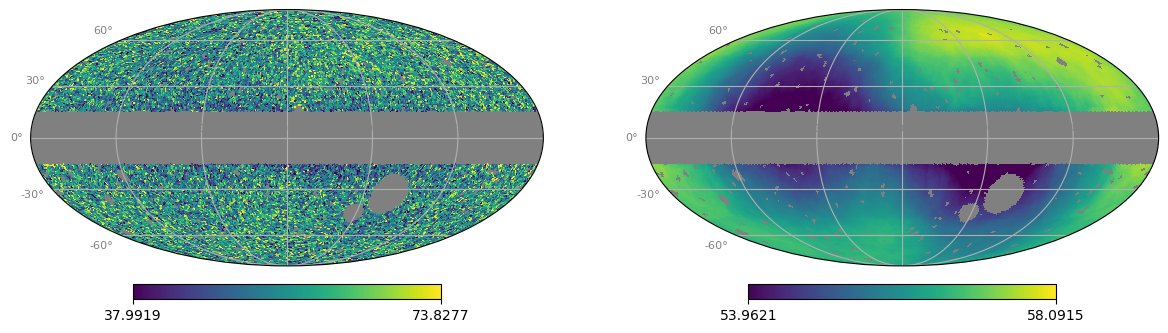

In [9]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8})
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.projview(masked_datamap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)
mean, std = np.nanmean(smoothed_map), np.nanstd(smoothed_map)
hp.projview(smoothed_map, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)

In [16]:
# fit dipole (ignore masked pixels)
amps, stderr = dipole.fit_dipole(masked_datamap_blim30, idx=~np.isnan(masked_datamap_blim30))
dipole_amp, dipole_dir = dipole.get_dipole(amps, frame='icrs')
amps, dipole_amp, dipole_dir.galactic

(array([56.53389241, -0.70586882,  0.58800954, -0.24929021]),
 0.016838040463468495,
 <SkyCoord (Galactic): (l, b) in deg
     (246.0246517, 23.67984004)>)

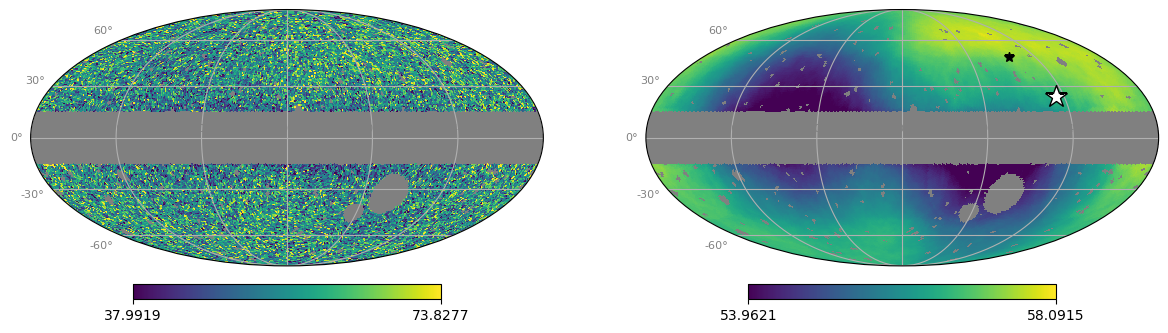

In [17]:
# plot: with dipoles
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8})
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.projview(masked_datamap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)
mean, std = np.nanmean(smoothed_map), np.nanstd(smoothed_map)
hp.projview(smoothed_map, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)

tools.plot_marker(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, c='k',
                  marker='*', ms=1000*catwise_dipamp_exp)
tools.plot_marker(dipole_dir.galactic.l.deg, dipole_dir.galactic.b.deg, c='w',
                  mec='k', lw=0.5, marker='*', ms=1000*dipole_amp)

In [18]:
# ** the plot in the Overleaf is the density map that's been corrected for a trend in absolute ecliptic latitude—
#  and actually the smoothed map looks fairly different after this correction!
t = d.load_hpxelatcorr()
elatcorrmap = np.full(hp.nside2npix(NSIDE), np.nan)
elatcorrmap[t['hpidx']] = t['elatdenscorr']
masked_elatcorrmap = np.multiply(elatcorrmap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

In [19]:
# smooth map
smoothed_elatcorrmap = tools.smooth_map(masked_elatcorrmap)

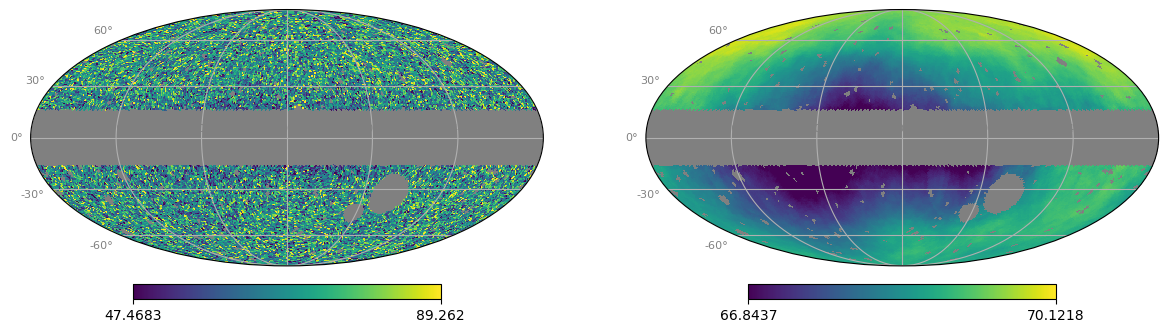

In [20]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8})
mean, std = np.nanmean(masked_elatcorrmap), np.nanstd(masked_elatcorrmap)
hp.projview(masked_elatcorrmap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)
mean, std = np.nanmean(smoothed_elatcorrmap), np.nanstd(smoothed_elatcorrmap)
hp.projview(smoothed_elatcorrmap, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)

In [22]:
# fit dipole (ignore masked pixels) * from blim=30 map *
masked_elatcorrmap_blim30 = np.multiply(elatcorrmap, mask_blim30, where=(mask_blim30!=0),
                                        out=np.full_like(elatcorrmap, np.nan))

amps, stderr = dipole.fit_dipole(masked_elatcorrmap_blim30, idx=~np.isnan(masked_elatcorrmap_blim30))
dipole_amp, dipole_dir = dipole.get_dipole(amps, frame='icrs')
amps, dipole_amp, dipole_dir.galactic

(array([68.96243182, -0.78652973,  0.66026973, -0.09621845]),
 0.01495637097273389,
 <SkyCoord (Galactic): (l, b) in deg
     (237.15001116, 29.4928544)>)

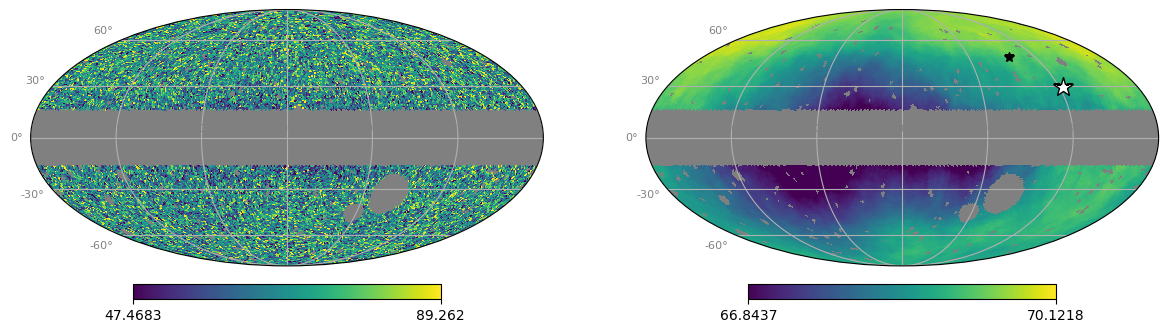

In [23]:
# plot: with dipoles
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8})
mean, std = np.nanmean(masked_elatcorrmap), np.nanstd(masked_elatcorrmap)
hp.projview(masked_elatcorrmap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)
mean, std = np.nanmean(smoothed_elatcorrmap), np.nanstd(smoothed_elatcorrmap)
hp.projview(smoothed_elatcorrmap, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)

tools.plot_marker(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, c='k',
                  marker='*', ms=1000*catwise_dipamp_exp)
tools.plot_marker(dipole_dir.galactic.l.deg, dipole_dir.galactic.b.deg, c='w',
                  mec='k', lw=0.5, marker='*', ms=1000*dipole_amp)

In [24]:
# Quaia overdensity map

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=15, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# and load selection function
selfunc = d.load_selfunc()

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
datamap_corr = np.divide(datamap, selfunc, where=(selfunc>0.5), out=np.full_like(datamap, np.nan))
masked_datamap = np.multiply(datamap_corr, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# fit dipole (and other multipoles) from blim=30 map
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= 30] = 1
mask_blim30 = gal_plane_mask.astype(bool) & small_masks.astype(bool)
datamap_corr = np.divide(datamap, selfunc, where=(selfunc>0.5), out=np.full_like(datamap, np.nan))
masked_datamap_blim30 = np.multiply(datamap_corr, mask_blim30, where=(mask_blim30!=0),
                                    out=np.full_like(datamap, np.nan))

# OVERDENSITIES
overdensity_map_quaia = masked_datamap_blim30 / np.nanmean(masked_datamap_blim30) - 1

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


In [25]:
# smooth map (steradian scale)
smoothed_map = tools.smooth_map(masked_datamap)

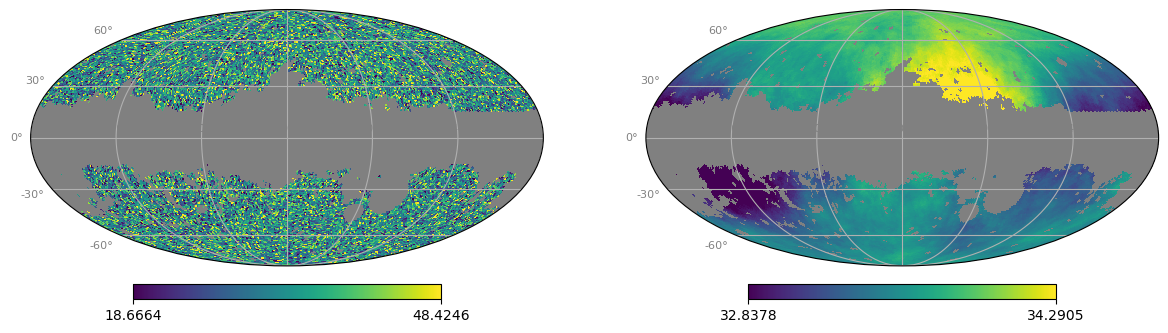

In [26]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8})
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.projview(masked_datamap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)
mean, std = np.nanmean(smoothed_map), np.nanstd(smoothed_map)
hp.projview(smoothed_map, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)

In [27]:
# fit dipole (ignore masked pixels)
amps, stderr = dipole.fit_dipole(masked_datamap_blim30, idx=~np.isnan(masked_datamap_blim30))
dipole_amp, dipole_dir = dipole.get_dipole(amps, frame='icrs')
amps, dipole_amp, dipole_dir.galactic

(array([33.62529882, -0.38774051, -0.21101735, -0.3091352 ]),
 0.0160272410764415,
 <SkyCoord (Galactic): (l, b) in deg
     (317.22104954, 26.12058366)>)

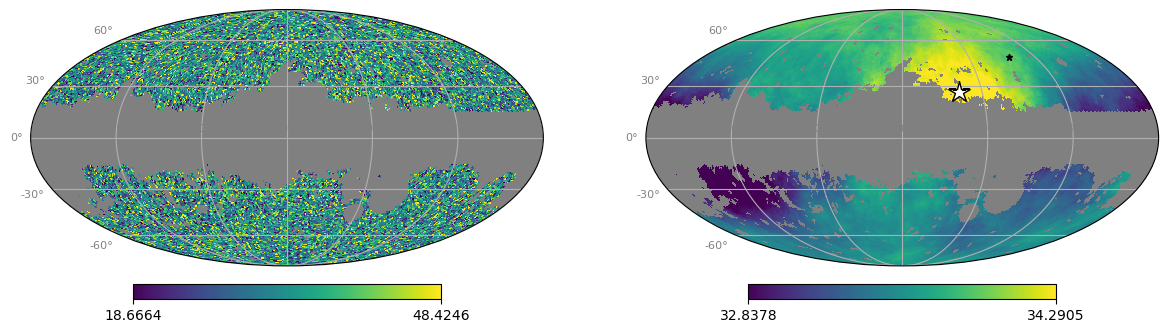

In [28]:
# plot: with dipoles
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], graticule=True, graticule_labels=True,
             xtick_label_color='grey', ytick_label_color='grey', fontsize={'xtick_label':8, 'ytick_label':8})
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.projview(masked_datamap, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)
mean, std = np.nanmean(smoothed_map), np.nanstd(smoothed_map)
hp.projview(smoothed_map, sub=(1,2,2), min=mean-2*std, max=mean+2*std, **kwargs)

tools.plot_marker(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, c='k',
                  marker='*', ms=1000*quaia_dipamp_exp)
tools.plot_marker(dipole_dir.galactic.l.deg, dipole_dir.galactic.b.deg, c='w',
                  mec='k', lw=0.5, marker='*', ms=1000*dipole_amp)

### angular power spectra

In [29]:
# maps to fit: overdensities; set masked pixels to zero counts
map_to_fit_catwise = overdensity_map_catwise.copy()
idx_masked_catwise = np.isnan(map_to_fit_catwise)
map_to_fit_catwise[idx_masked_catwise] = 0.

map_to_fit_quaia = overdensity_map_quaia.copy()
idx_masked_quaia = np.isnan(map_to_fit_quaia)
map_to_fit_quaia[idx_masked_quaia] = 0.

In [30]:
# choose a max ell and weights in the masked pixels
max_ell = 10
Wmask = 1.

In [31]:
# QUAIA
# weights: selfunc in unmasked pixels, Wmask in the masked pixels
Cinv_ = selfunc.copy()
Cinv_[idx_masked_quaia] = Wmask
ells, Cells_quaia, alms = Cells_from_alms_fit(map_to_fit_quaia, Cinv_, max_ell, return_alms=True)
# get dipole direction: need to insert a 1 monopole since we're fitting overdensities
dipdir_quaia = dipole.get_dipole(np.append(1,[alms[3],alms[1],alms[2]]))[1]

# CATWISE
# weights: identity (assuming completeness=1) in unmasked pixels, Wmask in the masked pixels
Cinv_ = np.ones_like(map_to_fit_catwise)
Cinv_[idx_masked_quaia] = Wmask
ells, Cells_catwise, alms = Cells_from_alms_fit(map_to_fit_catwise, Cinv_, max_ell, return_alms=True)
# get dipole direction: need to insert a 1 monopole since we're fitting overdensities
dipdir_catwise = dipole.get_dipole(np.append(1,[alms[3],alms[1],alms[2]]))[1]

In [32]:
# load in best-fit Quaia model from David
with np.load('/scratch/aew492/quasars/quaia_PS/cl_gg_bf_G20.0_1bin.npz') as res:
    ell_model = res['ell']
    cl_gg_model = res['cl_gg']

In [33]:
# shot noise: estimate from the correlations sent by Giulio
res = np.load(f'/scratch/aew492/quasars/quaia_PS/G20.0_selfunc50_remove_dipole_True.pkl', allow_pickle=True)
data_res = res['nmt']['diagk_corrg']['data']
gjkgjk = data_res[('gjk_sel','gjk_sel')]
ell_noise = res['nmt']['lb']
noise = np.mean(gjkgjk[ell_noise<=max_ell])
noise

1.1924599981309956e-05

In [34]:
# kinematic expectation

# convert (l,b) to a 3D vector on the sky
vec_qso  = hp.ang2vec(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, lonlat=True)
# vector for every healpixel on the sky
vecs = hp.pix2vec(NSIDE, np.arange(hp.nside2npix(NSIDE))) # NSIDE defined at beginning of notebook

# cosine between every healpixel and the dipole peak
costheta = np.dot(np.array(vecs).T, vec_qso)

# the expected dipole
dipole_qso_catwise = catwise_dipamp_exp * costheta
dipole_qso_quaia = quaia_dipamp_exp * costheta
# the expected quadrupole
quadrupole_qso_catwise = catwise_dipamp_exp**2 * 3 * (3 * costheta**2 - 1) / 2
quadrupole_qso_quaia = quaia_dipamp_exp**2 * 3 * (3 * costheta**2 - 1) / 2

# Cells of the combined map, only up to the quadrupole
Cells_exp_catwise = hp.anafast(dipole_qso_catwise + quadrupole_qso_catwise, lmax=2)
Cells_exp_quaia = hp.anafast(dipole_qso_quaia + quadrupole_qso_quaia, lmax=2)

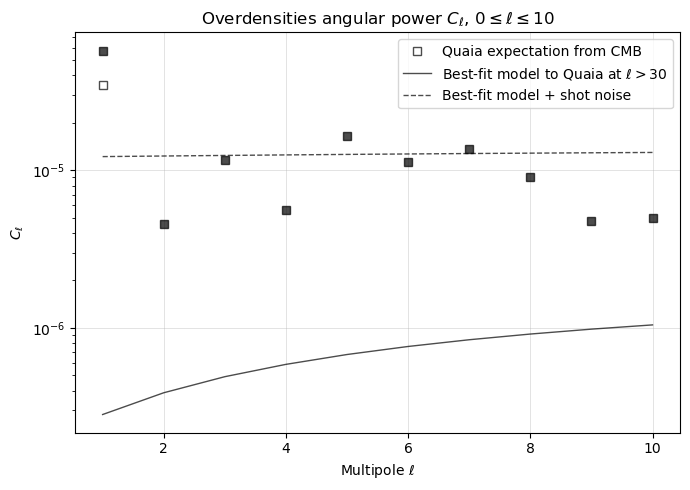

In [38]:
# plottt: Quaia only
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', alpha=0.7, mec='k')

ax.plot(ells[1:], Cells_quaia[1:], marker='s', c='k', **kwargs)
ax.plot([1], Cells_exp_quaia[1], c='None', mec='k', alpha=0.7, ls='None', marker='s',
        label='Quaia expectation from CMB')

idx = (ell_model <= max_ell)
ax.plot(ell_model[idx], cl_gg_model[idx], c='k', alpha=0.7, lw=1,
        label=r'Best-fit model to Quaia at $\ell>30$')
ax.plot(ell_model[idx], cl_gg_model[idx]+noise, c='k', alpha=0.7, lw=1, ls='--',
        label=r'Best-fit model + shot noise')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

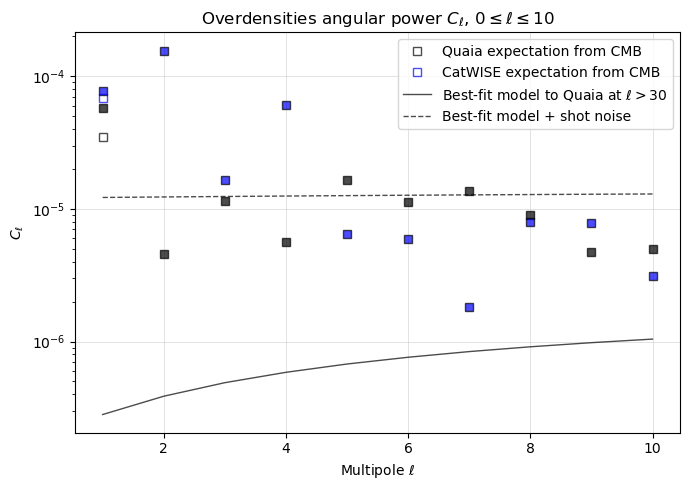

In [39]:
# plottt: Quaia + CatWISE
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', alpha=0.7, mec='k')

ax.plot(ells[1:], Cells_quaia[1:], marker='s', c='k', **kwargs)
ax.plot([1], Cells_exp_quaia[1], c='None', mec='k', alpha=0.7, ls='None', marker='s',
        label='Quaia expectation from CMB')
ax.plot(ells[1:], Cells_catwise[1:], marker='s', c='b', **kwargs)
ax.plot([1], Cells_exp_catwise[1], c='None', mec='b', alpha=0.7, ls='None', marker='s',
        label='CatWISE expectation from CMB')

idx = (ell_model <= max_ell)
ax.plot(ell_model[idx], cl_gg_model[idx], c='k', alpha=0.7, lw=1,
        label=r'Best-fit model to Quaia at $\ell>30$')
ax.plot(ell_model[idx], cl_gg_model[idx]+noise, c='k', alpha=0.7, lw=1, ls='--',
        label=r'Best-fit model + shot noise')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()